# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST
테스트 데이터로 제공

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
28*28

784

Saving figure some_digit_plot


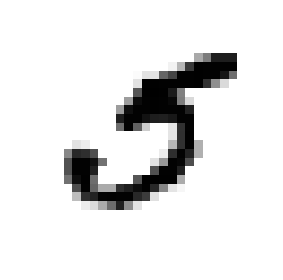

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


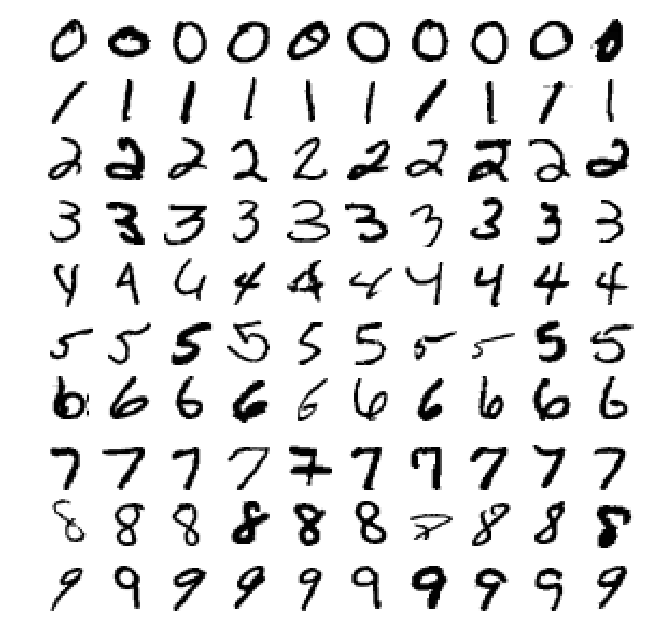

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [9]:
# split training set and testset (60000, 10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# cross-validation 할때 같은 번호들이 선택되지 않고 골고루 선택되기 위해 shuffling 함 

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [11]:
# 5 이거나 혹은 아니거나로 분류해보기 

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# Stochastic Gradient Descent (SGD) classifier, 
# using Scikit-Learn’s SGDClassifier class. (큰 데이터셋과 online learning 에 적합하다.)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [13]:
# 숫자 5를 알수 있도록 함 predict 
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## IMPLEMENTING CROSS-VALIDATION
StratifiedKFold : class 의 비율별로 test, train 을 나누고 fold 를 만듬 

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    # test set 을 모델에 넣어 prediction 값을 꺼내고 맞는 비율을 확인
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


## Measuring Accuracy Using Cross-Validation 

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

In [16]:
# 5가 아닌 class 들 확인

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

이미지의 10% 만이 5이기 때문에 모델의 정확도가 90%가 나왔다. 
비 대칭 데이터 세트 

## Confusion Matrix
분류를 구분하기에 좋은 방법으로
A 로 분류 해야 하는것을 B 로 했는지 알수 있다.

In [17]:
# 예측 값을 구함
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
# 예측 값과 실제 정답을 넣고 돌림
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

|  |Negative |Positive|
|:--------- |:---------|:---------|
|Negative |실제 5가 아닌데 5가 아닌라고 판단 | 5가 아닌데 5라고 판단|
|Positive|5인데 5가 아니라고 함 | 5인데 5가 아니라고함 |

* 1307, 1077 은 예측을 잘못한 값

실제 값을 넣었을 때 Confusion Matrix

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* Precision : 예측의 정확성, 긍정적으로 예측한것 중에 진짜 긍정적인인 비율 
>![alt text](3precision.png "precision")

* Recall : 실제 긍정적인 비율중에 정확히 검출된 긍정적인 비율 
>![alt text](3recall.png "recall")

>![alt text](3TNFP.png "recall")

## Precision and Recall

잘 예측한것 

In [20]:
from sklearn.metrics import precision_score, recall_score

print(4344 / (4344 + 1307))
precision_score(y_train_5, y_train_pred)

0.7687135020350381


0.76871350203503808

잘 예측된것

In [21]:
print(4344 / (4344 + 1077))
recall_score(y_train_5, y_train_pred)

0.801328168234643


0.80132816823464303

* F1 Score : Predicsion 과 recall 을 합쳐서 확인함
> ![alt text](3f1score.png "f1 score")

In [22]:
from sklearn.metrics import f1_score
print(4344 / (4344 + (1077 + 1307)/2))
f1_score(y_train_5, y_train_pred)

0.7846820809248555


0.78468208092485547

precision 과 recall 중 더 중요하게 생각 해야 되는 부분이 다르다.

어린아이에게 비디오를 보여주는 경우 안전한 것만 보여주도록 _precision_ 을 중요하게 생각하고 <br>
도둑을 잡기위해서는 잘못된 곳에 경고가 울려 경비가 출동하더라도 모든 도둑을 잡을 수 있도록 _recall_ 을 중요하게 생각 해야 한다. 

## Precision/Recall Tradeoff

이전에 생성한 SGD Classifier 의 결과를 이용 (Stochastic gradient descent) <br>
predict() -> decision function 을 기반으로 점수가 계산되고 <br>
점수가 임계치 보다 크면 긍정 클래스를 할당하고 그렇지 않으면 부정 클래스를 할당
> ![alt text](3Tradeoff.png "tradeoff")

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [24]:
#SGD 기본 임계치는 0 으로 잡혀 있음 
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [25]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [26]:
# 모든 인스턴스점수 예측 대신 결정 스코어 리턴 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


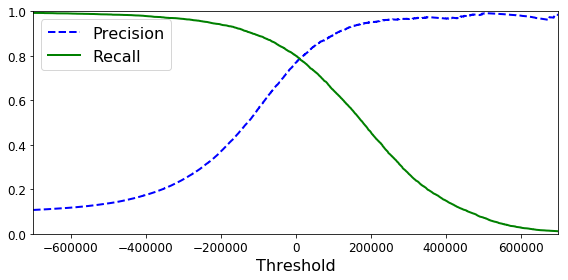

In [28]:
# 모든 임계치의 precision, recall 보기 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [29]:
(y_train_pred == (y_scores > 0)).all()

True

In [30]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.86592051164915484

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172

Saving figure precision_vs_recall_plot


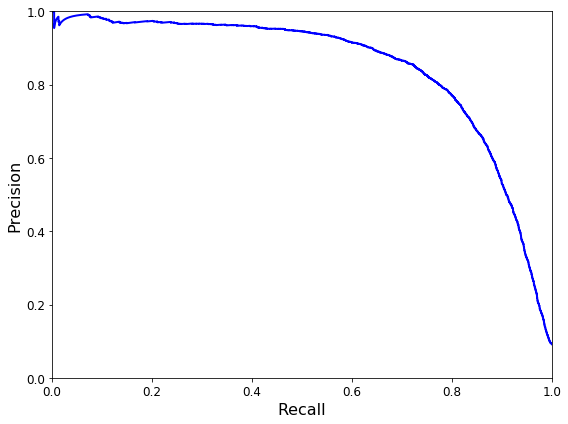

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()